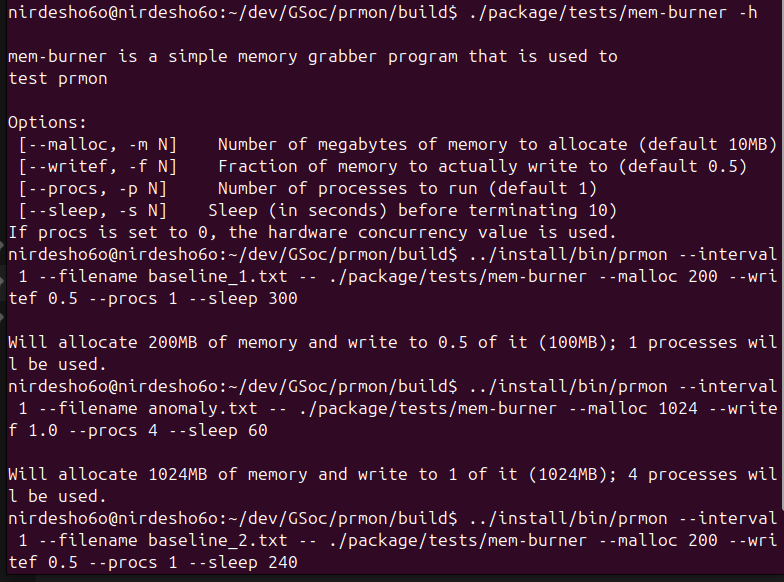

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [2]:
base_1 = pd.read_csv('base_1.txt', sep=r'\s+')
anom_spike = pd.read_csv('anom_spike.txt',sep=r'\s+')
base_2 = pd.read_csv('base_2.txt', sep=r'\s+')
anom_sustained = pd.read_csv('anom_sustained.txt', sep=r'\s+')

In [3]:
base_1['is_anomaly'] = 0
anom_spike['is_anomaly'] = 1
base_2['is_anomaly'] = 0
anom_sustained['is_anomaly'] = 1

In [4]:
df = pd.concat([base_1, anom_spike, base_2, anom_sustained], ignore_index=True)

In [5]:
df.sample(5)

,Time,wtime,pss,rss,swap,vmem,rchar,read_bytes,wchar,write_bytes,rx_bytes,rx_packets,tx_bytes,tx_packets,stime,utime,nprocs,nthreads,is_anomaly
8,1772196315,16,98055,101456,0,201688,6593,0,88,0,253773,1761,147918,181,0,0,1,1,0
21,1772196341,42,98055,101456,0,201688,6593,0,88,0,594141,4420,362711,431,0,0,1,1,0
386,1772197066,162,469138,472512,0,592312,6593,0,88,0,11269938,26714,1721226,6417,0,0,1,1,1
371,1772197036,132,469138,472512,0,592312,6593,0,88,0,10899427,23591,1630295,6175,0,0,1,1,1
192,1772196680,76,98052,101448,0,201688,6593,0,88,0,1465315,9364,551793,1078,0,0,1,1,0


In [6]:
df['continuous_time'] = df.index

In [7]:
df.head(5)

,Time,wtime,pss,rss,swap,vmem,rchar,read_bytes,wchar,write_bytes,rx_bytes,rx_packets,tx_bytes,tx_packets,stime,utime,nprocs,nthreads,is_anomaly,continuous_time
0,1772196299,0,14396,17700,0,201688,6593,0,88,0,0,0,0,0,0,0,1,1,0,0
1,1772196301,2,98025,101456,0,201688,6593,0,88,0,60238,255,51415,43,0,0,1,1,0,1
2,1772196303,4,98025,101456,0,201688,6593,0,88,0,99909,525,72798,82,0,0,1,1,0,2
3,1772196305,6,98025,101456,0,201688,6593,0,88,0,124324,816,73556,86,0,0,1,1,0,3
4,1772196307,8,98025,101456,0,201688,6593,0,88,0,150527,1015,87640,108,0,0,1,1,0,4


# PARAMETERS

In [8]:
window_size = 30
threshold_k = 3
k_consecutive = 5

# DETECTOR 1: Rolling MAD (For Transient Spikes)

In [9]:
df['rolling_median'] = (
    df['pss']
    .rolling(window=window_size, min_periods=window_size)
    .median()
    .shift(1)
)


df['abs_dev'] = (df['pss'] - df['rolling_median']).abs()


df['rolling_mad'] = (
    df['abs_dev']
    .rolling(window=window_size, min_periods=window_size)
    .median()
    .shift(1)
)


df['robust_z_score'] = (
    (df['pss'] - df['rolling_median']) /
    (1.4826 * df['rolling_mad'] + 1e-6)
)

df['alert_spike'] = (df['robust_z_score'] > threshold_k).astype(int)

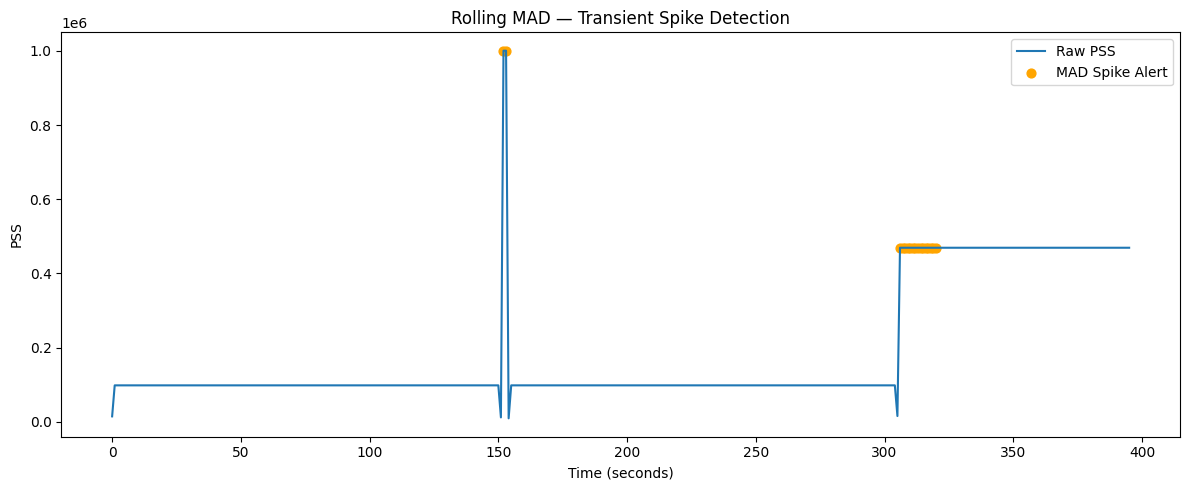

In [10]:
plt.figure(figsize=(12,5))

plt.plot(df['continuous_time'], df['pss'], label='Raw PSS', linewidth=1.5)

plt.scatter(
    df.loc[df['alert_spike'] == 1, 'continuous_time'],
    df.loc[df['alert_spike'] == 1, 'pss'],
    color='orange',
    s=40,
    label='MAD Spike Alert'
)

plt.title("Rolling MAD — Transient Spike Detection")
plt.xlabel("Time (seconds)")
plt.ylabel("PSS")
plt.legend()
plt.tight_layout()
plt.show()

# DETECTOR 2: EWMA (For Sustained Regressions / Drifts)

In [11]:

df['ewma_baseline'] = df['pss'].ewm(span=200, adjust=False).mean()

df['ewma_residual'] = df['pss'] - df['ewma_baseline']

df['residual_std'] = (
    df['ewma_residual']
    .rolling(window=60, min_periods=60)
    .std()
)
df['residual_std'] = df['residual_std'].clip(lower=df['pss'].std() * 0.02)
df['ewma_outlier'] = (
    df['ewma_residual'] > 3 * df['residual_std']
).astype(int)
df['alert_drift'] = (
    df['ewma_outlier']
    .rolling(window=5)
    .sum() >= 5
).astype(int)

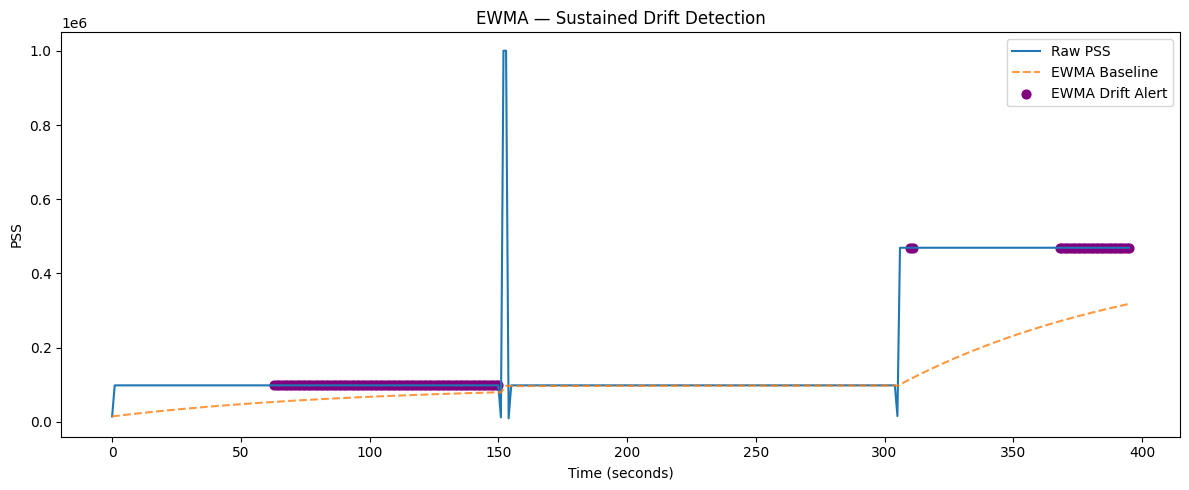

In [12]:
plt.figure(figsize=(12,5))

plt.plot(df['continuous_time'], df['pss'], label='Raw PSS', linewidth=1.5)
plt.plot(df['continuous_time'], df['ewma_baseline'], 
         linestyle='--', alpha=0.8, label='EWMA Baseline')

plt.scatter(
    df.loc[df['alert_drift'] == 1, 'continuous_time'],
    df.loc[df['alert_drift'] == 1, 'pss'],
    color='purple',
    s=40,
    label='EWMA Drift Alert'
)

plt.title("EWMA — Sustained Drift Detection")
plt.xlabel("Time (seconds)")
plt.ylabel("PSS")
plt.legend()
plt.tight_layout()
plt.show()

# DETECTOR 3: Isolation Forest (For Structural / Complex Anomalies)

In [13]:

df['pss_diff'] = df['pss'].diff().fillna(0)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['pss', 'pss_diff']])


baseline_cutoff = 250  # adjust if needed
baseline_indices = df['continuous_time'] < baseline_cutoff

if_model = IsolationForest(contamination=0.02, random_state=42)
if_model.fit(scaled_features[baseline_indices])


df['if_score'] = if_model.predict(scaled_features)

df['alert_structural'] = (df['if_score'] == -1).astype(int)

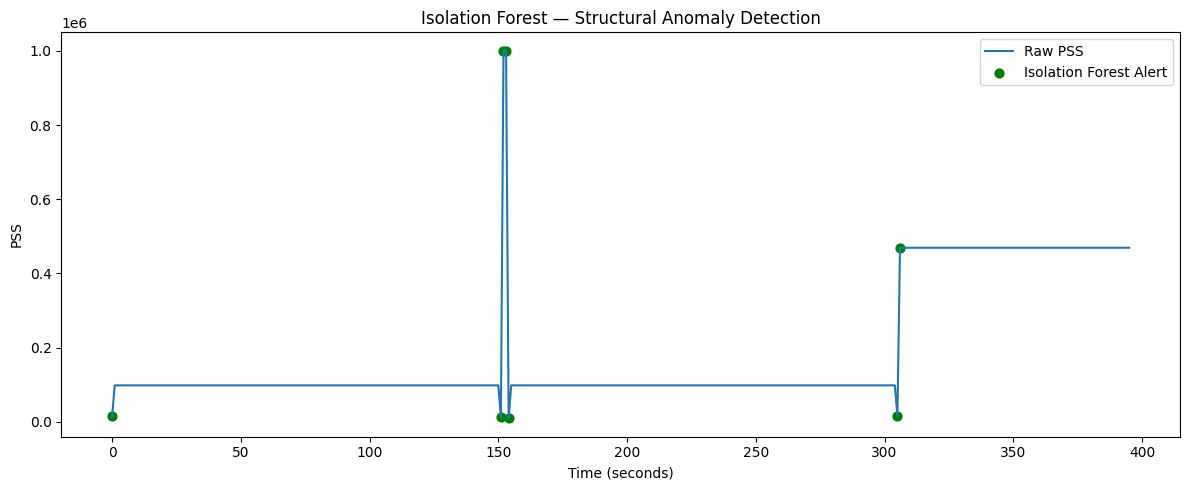

In [14]:
plt.figure(figsize=(12,5))

plt.plot(df['continuous_time'], df['pss'], label='Raw PSS', linewidth=1.5)

plt.scatter(
    df.loc[df['alert_structural'] == 1, 'continuous_time'],
    df.loc[df['alert_structural'] == 1, 'pss'],
    color='green',
    s=40,
    label='Isolation Forest Alert'
)

plt.title("Isolation Forest — Structural Anomaly Detection")
plt.xlabel("Time (seconds)")
plt.ylabel("PSS")
plt.legend()
plt.tight_layout()
plt.show()

# FINAL ALERT COMBINATION

In [15]:
df['alert_types'] = ''

df.loc[df['alert_spike'] == 1, 'alert_types'] += 'Spike;'
df.loc[df['alert_structural'] == 1, 'alert_types'] += 'Structural;'
df.loc[df['alert_drift'] == 1, 'alert_types'] += 'Drift;'

df['alert_types'] = df['alert_types'].replace('', 'Normal')

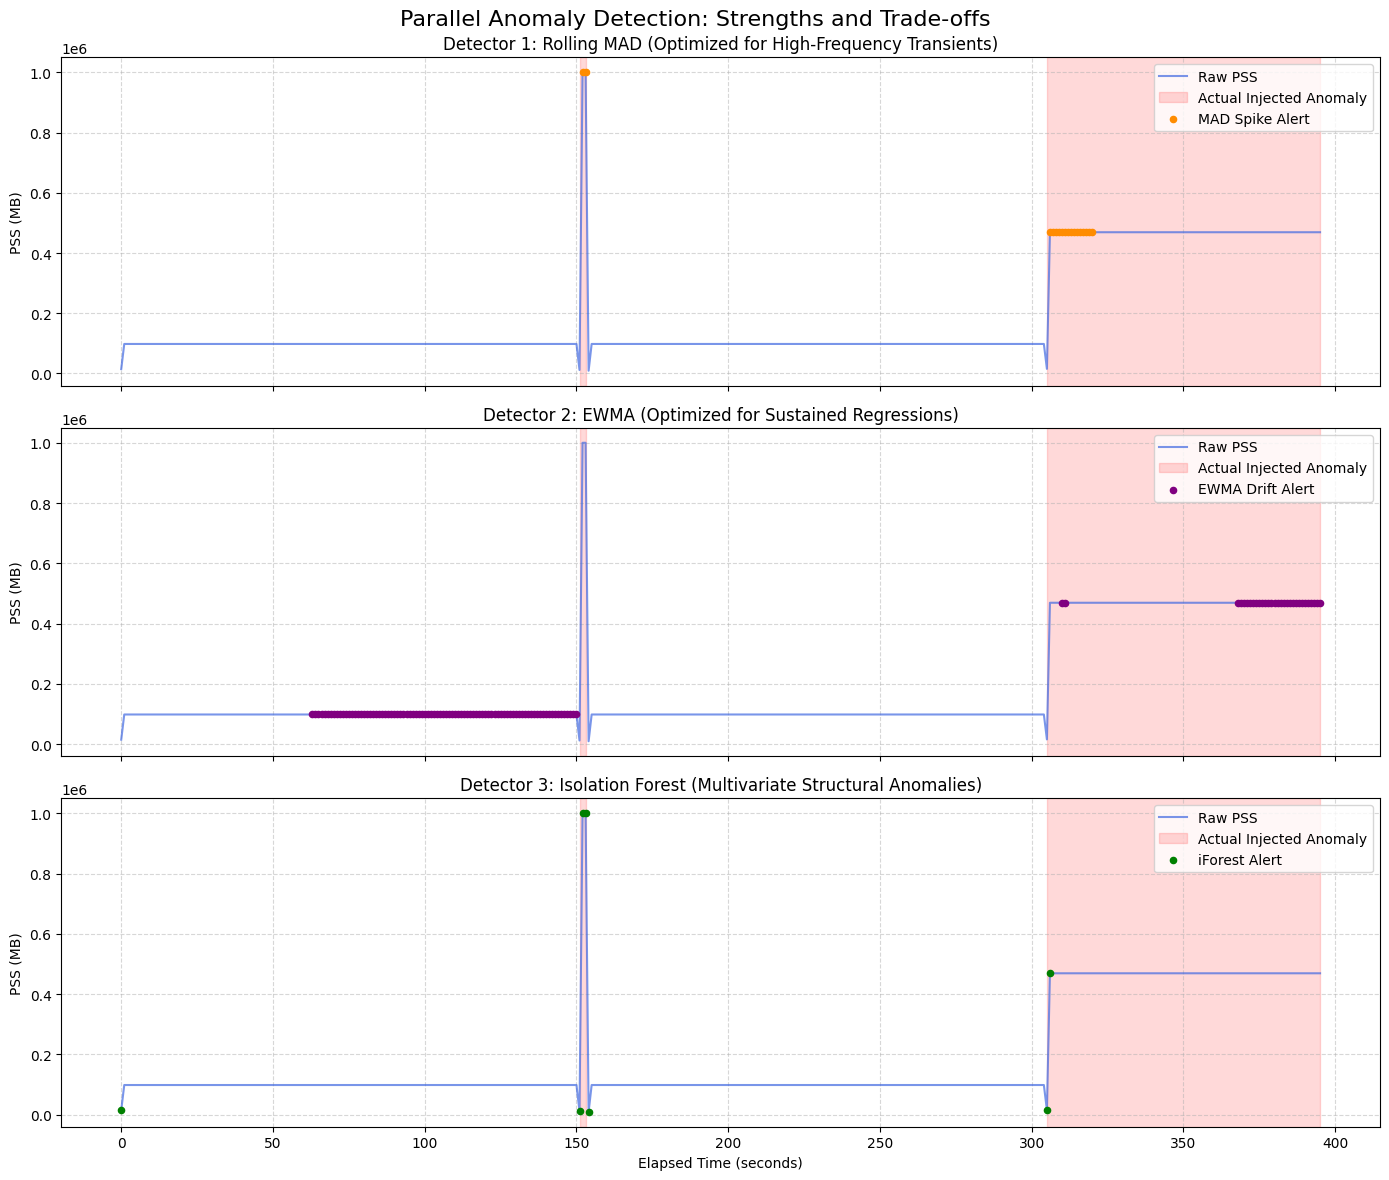

In [16]:

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle('Parallel Anomaly Detection: Strengths and Trade-offs', fontsize=16, y=0.98)

# Helper function to softly shade the actual anomalies in the background
def plot_ground_truth(ax):
    anomaly_regions = df[df['is_anomaly'] == 1]
    if not anomaly_regions.empty:

        groups = (anomaly_regions.index.to_series().diff() != 1).cumsum()
        for _, group in anomaly_regions.groupby(groups):
            ax.axvspan(group['continuous_time'].iloc[0], group['continuous_time'].iloc[-1], 
                       color='red', alpha=0.15, label='Actual Injected Anomaly' if _ == 1 else "")

#  Rolling MAD
axes[0].plot(df['continuous_time'], df['pss'], color='royalblue', alpha=0.7, label='Raw PSS')
plot_ground_truth(axes[0])
mad_alerts = df[df['alert_spike'] == 1]
axes[0].scatter(mad_alerts['continuous_time'], mad_alerts['pss'], color='darkorange', 
                label='MAD Spike Alert', zorder=5, s=20)
axes[0].set_title('Detector 1: Rolling MAD (Optimized for High-Frequency Transients)')
axes[0].set_ylabel('PSS (MB)')
axes[0].legend(loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.5)

#  EWMA 
axes[1].plot(df['continuous_time'], df['pss'], color='royalblue', alpha=0.7, label='Raw PSS')
plot_ground_truth(axes[1])
ewma_alerts = df[df['alert_drift'] == 1]
axes[1].scatter(ewma_alerts['continuous_time'], ewma_alerts['pss'], color='purple', 
                label='EWMA Drift Alert', zorder=5, s=20)
axes[1].set_title('Detector 2: EWMA (Optimized for Sustained Regressions)')
axes[1].set_ylabel('PSS (MB)')
axes[1].legend(loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.5)

#  Isolation Forest 
axes[2].plot(df['continuous_time'], df['pss'], color='royalblue', alpha=0.7, label='Raw PSS')
plot_ground_truth(axes[2])
if_alerts = df[df['alert_structural'] == 1]
axes[2].scatter(if_alerts['continuous_time'], if_alerts['pss'], color='green', 
                label='iForest Alert', zorder=5, s=20)
axes[2].set_title('Detector 3: Isolation Forest (Multivariate Structural Anomalies)')
axes[2].set_ylabel('PSS (MB)')
axes[2].set_xlabel('Elapsed Time (seconds)')
axes[2].legend(loc='upper right')
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Helper function to print metrics cleanly
def print_metrics(model_name, y_true, y_pred):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{model_name} - Precision: {p:.2f} | Recall: {r:.2f} | F1: {f1:.2f}")

print_metrics("Rolling MAD", df['is_anomaly'], df['alert_spike'])
print_metrics("EWMA", df['is_anomaly'], df['alert_drift'])
print_metrics("Isolation Forest", df['is_anomaly'], df['alert_structural'])

# Combined Pipeline (Alerts if ANY detector fires)
df['combined_alert'] = df[['alert_spike', 'alert_drift', 'alert_structural']].max(axis=1)
print_metrics("Combined Pipeline", df['is_anomaly'], df['combined_alert'])

Rolling MAD - Precision: 1.00 | Recall: 0.18 | F1: 0.31
EWMA - Precision: 0.25 | Recall: 0.32 | F1: 0.28
Isolation Forest - Precision: 0.71 | Recall: 0.05 | F1: 0.10
Combined Pipeline - Precision: 0.34 | Recall: 0.50 | F1: 0.41
